In [2]:
# Cell 1: Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf  # Check if TensorFlow is imported correctly
from tensorflow import keras
from keras import layers  # Changed to match the standalone Keras
from keras_tuner import RandomSearch
from sklearn.model_selection import train_test_split

In [3]:
# Load MNIST dataset
mnist = keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()


In [4]:
# Normalize the data
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0


In [5]:
# Split the training data into sub_train and valid
sub_train, valid, y_sub_train, y_valid = train_test_split(x_train, y_train, test_size=10000, random_state=42)


In [6]:
# Reshape the data to be suitable for the neural network
sub_train = sub_train.reshape((50000, 28, 28, 1))
valid = valid.reshape((10000, 28, 28, 1))
x_test = x_test.reshape((10000, 28, 28, 1))


In [7]:
# Define the function to build the model
def build_model(hp):
    model = keras.Sequential()
    # Tune the width and depth of the model
    for i in range(hp.Int('num_layers', 1, 3)):  # Experiment with 1 to 3 layers
        model.add(layers.Flatten(input_shape=(28, 28, 1)))  # Flatten the input
        model.add(layers.Dense(units=hp.Int('units_' + str(i), min_value=32, max_value=512, step=32),
                               activation=hp.Choice('activation_' + str(i), values=['relu', 'tanh', 'sigmoid'])))
    
    # Add the output layer
    model.add(layers.Dense(10, activation='softmax'))  # 10 classes for MNIST

    # Compile the model with the cross-entropy loss function
    model.compile(
        optimizer=keras.optimizers.Adam(
            learning_rate=hp.Float('learning_rate', min_value=1e-4, max_value=1e-1, sampling='LOG'),
            beta_1=hp.Float('beta_1', min_value=0.8, max_value=0.99, step=0.01),
            beta_2=hp.Float('beta_2', min_value=0.9, max_value=0.999, step=0.01)
        ),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model


In [8]:
# Instantiate the RandomSearch tuner
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=20,  # More than 10 trials
    directory='my_dir',
    project_name='mnist_hyperparameter_tuning'
)


Reloading Tuner from my_dir/mnist_hyperparameter_tuning/tuner0.json


In [9]:
# Get the optimal hyperparameters
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]


In [10]:
# Build the model with the best hyperparameters
best_model = tuner.hypermodel.build(best_hyperparameters)


/opt/anaconda3/envs/CECS406/lib/python3.9/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [11]:
# Train the best model
history = best_model.fit(sub_train, y_sub_train, epochs=10, validation_data=(valid, y_valid))


Epoch 1/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.8321 - loss: 0.7135 - val_accuracy: 0.9465 - val_loss: 0.1917
Epoch 2/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.9536 - loss: 0.1653 - val_accuracy: 0.9652 - val_loss: 0.1202
Epoch 3/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.9701 - loss: 0.1027 - val_accuracy: 0.9694 - val_loss: 0.1037
Epoch 4/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.9789 - loss: 0.0722 - val_accuracy: 0.9746 - val_loss: 0.0841
Epoch 5/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.9836 - loss: 0.0533 - val_accuracy: 0.9759 - val_loss: 0.0776
Epoch 6/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.9882 - loss: 0.0417 - val_accuracy: 0.9779 - val_loss: 0.0702
Epoch 7/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.9912 - loss: 0.0314 - val_accuracy: 0.9776 - val_loss: 0.0765
Epoch 8/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.9939 - loss: 0.0

In [12]:
# Evaluate the best model on the test data
test_loss, test_accuracy = best_model.evaluate(x_test, y_test)
print(f"Test accuracy: {test_accuracy:.4f}")


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9743 - loss: 0.0870
Test accuracy: 0.9770


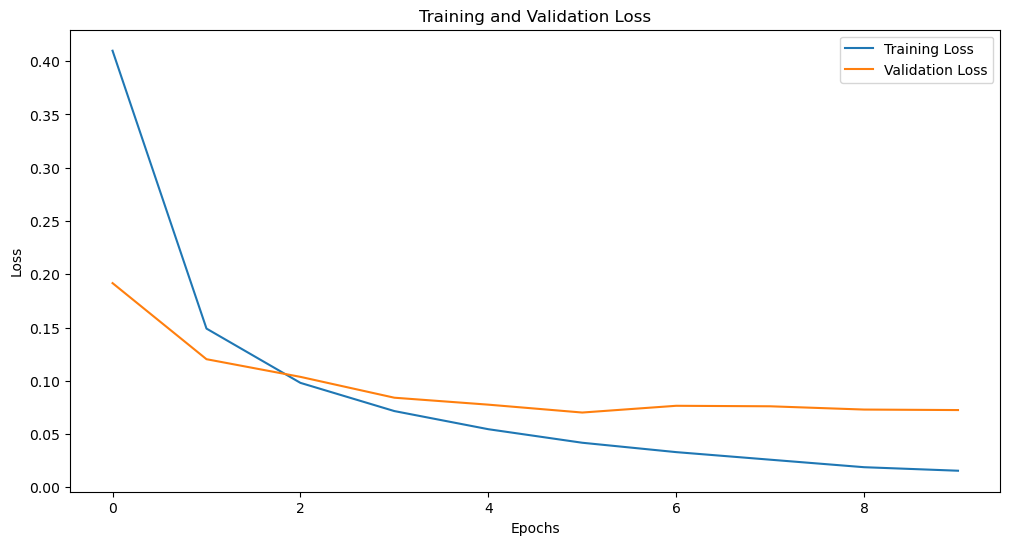

In [13]:
# Train the best model
history = best_model.fit(sub_train, y_sub_train, epochs=10, validation_data=(valid, y_valid))

# Evaluate the best model on the test data
test_loss, test_accuracy = best_model.evaluate(x_test, y_test)

# Plot training and validation loss curves
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()